In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import precision_score, recall_score, mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
import joblib

In [4]:
df = pd.read_csv('customer_data_10000.csv')
print(df.head())

   Customer_ID  Booking_Frequency  Avg_Spending  Preferred_Service  \
0         1001               11.0         412.0   Remedial Massage   
1         1002                2.0          67.0  Corporate Massage   
2         1003                1.0         305.0             Facial   
3         1004                5.0         997.0    Swedish Massage   
4         1005                4.0         808.0   Hair and Make Up   

                         Review_Text Last_Activity  
0      Absolutely fantastic service.    2024-09-23  
1              Loved the experience!    2023-12-16  
2    Incredible attention to detail.    2022-03-08  
3  Excellent and professional staff.    2024-07-23  
4                 Best massage ever!    2023-12-05  


In [5]:
service_stats = df.groupby('Preferred_Service').agg({
    'Booking_Frequency': 'mean',
    'Avg_Spending': 'mean',
    'Review_Text': lambda x: ' '.join(x.dropna())
}).reset_index()

print("\nService statistics:")
print(service_stats[['Preferred_Service', 'Booking_Frequency', 'Avg_Spending']].head())



Service statistics:
                Preferred_Service  Booking_Frequency  Avg_Spending
0               Corporate Massage           6.072125    615.724609
1                  Couple Massage           6.038679    624.028409
2                          Facial           6.141501    618.625967
3  Hair Cut Colouring and Styling           5.883030    607.700667
4                Hair and Make Up           6.308895    629.069540


In [6]:
tfidf = TfidfVectorizer(
    min_df=2,
    max_df=0.95,
    max_features=200,
    stop_words='english'
)


In [7]:
# Apply TF-IDF to the combined review text
service_reviews_tfidf = tfidf.fit_transform(service_stats['Review_Text'])
service_reviews_df = pd.DataFrame(
    service_reviews_tfidf.toarray(),
    index=service_stats['Preferred_Service'],
    columns=tfidf.get_feature_names_out()
)

In [8]:
print("\nTF-IDF features extracted from reviews (sample):")
print(service_reviews_df.iloc[:3, :5])


TF-IDF features extracted from reviews (sample):
                        did  expensive      meet     needs     worth
Preferred_Service                                                   
Corporate Massage  0.577350   0.000000  0.577350  0.577350  0.000000
Couple Massage     0.218218   0.654654  0.218218  0.218218  0.654654
Facial             0.365148   0.547723  0.365148  0.365148  0.547723


In [9]:
service_numerical = service_stats.set_index('Preferred_Service')[['Booking_Frequency', 'Avg_Spending']]

# Scale numerical features
scaler = StandardScaler()
service_numerical_scaled = pd.DataFrame(
    scaler.fit_transform(service_numerical),
    index=service_numerical.index,
    columns=service_numerical.columns
)


In [10]:
service_features = pd.concat([service_numerical_scaled, service_reviews_df], axis=1)

print("\nFinal service feature matrix shape:", service_features.shape)
print("\nService feature matrix (sample):")
print(service_features.iloc[:3, :7])


Final service feature matrix shape: (9, 7)

Service feature matrix (sample):
                   Booking_Frequency  Avg_Spending       did  expensive  \
Preferred_Service                                                         
Corporate Massage          -0.079882     -0.464583  0.577350   0.000000   
Couple Massage             -0.336403      0.317886  0.218218   0.654654   
Facial                      0.452223     -0.191187  0.365148   0.547723   

                       meet     needs     worth  
Preferred_Service                                
Corporate Massage  0.577350  0.577350  0.000000  
Couple Massage     0.218218  0.218218  0.654654  
Facial             0.365148  0.365148  0.547723  


In [11]:
# Step 1: Identify each user's preferred service
user_preferred_service = df[['Customer_ID', 'Preferred_Service']].drop_duplicates()

# Step 2: Create user profiles by mapping their preferred service to service features
user_profiles = {}
for _, row in user_preferred_service.iterrows():
    user_id = row['Customer_ID']
    service = row['Preferred_Service']
    if service in service_features.index:
        user_profiles[user_id] = service_features.loc[service].to_dict()

In [12]:
# Convert user profiles to DataFrame for easier handling
user_profiles_df = pd.DataFrame.from_dict(user_profiles, orient='index')

print(f"\nCreated profiles for {len(user_profiles)} users")
print("\nSample user profile (first user, first 5 features):")
first_user = list(user_profiles.keys())[0]
sample_features = list(user_profiles[first_user].keys())[:5]
for feature in sample_features:
    print(f"{feature}: {user_profiles[first_user][feature]}")


Created profiles for 9813 users

Sample user profile (first user, first 5 features):
Booking_Frequency: 1.2425851371899188
Avg_Spending: -0.014017392880665749
did: 0.4472135954999579
expensive: 0.4472135954999579
meet: 0.4472135954999579


In [13]:
# Convert service features to a matrix for similarity calculation
service_feature_matrix = service_features.values
service_indices = {service: i for i, service in enumerate(service_features.index)}

# Calculate cosine similarity between services
service_similarity = cosine_similarity(service_feature_matrix)

# Create a DataFrame for the similarity matrix
service_similarity_df = pd.DataFrame(
    service_similarity,
    index=service_features.index,
    columns=service_features.index
)

In [14]:
print("\nService similarity matrix (sample):")
print(service_similarity_df.iloc[:5, :5])


Service similarity matrix (sample):
Preferred_Service               Corporate Massage  Couple Massage    Facial  \
Preferred_Service                                                             
Corporate Massage                        1.000000        0.211091  0.556311   
Couple Massage                           0.211091        1.000000  0.605490   
Facial                                   0.556311        0.605490  1.000000   
Hair Cut Colouring and Styling           0.498576        0.459788  0.217358   
Hair and Make Up                        -0.212860        0.250113  0.586613   

Preferred_Service               Hair Cut Colouring and Styling  \
Preferred_Service                                                
Corporate Massage                                     0.498576   
Couple Massage                                        0.459788   
Facial                                                0.217358   
Hair Cut Colouring and Styling                        1.000000   
Hair and Make

In [15]:
# Cell 6: Create recommendation function
def recommend_services(customer_id, top_n=3):
    """
    Recommend services for a specific customer based on their current preference.

    Parameters:
    customer_id: ID of the customer
    top_n: Number of recommendations to return

    Returns:
    List of recommended services
    """
    # Get customer's preferred service
    try:
        preferred_service = df[df['Customer_ID'] == customer_id]['Preferred_Service'].iloc[0]
    except IndexError:
        return "Customer ID not found"

    # Get similarity scores for the customer's preferred service
    if preferred_service not in service_similarity_df.index:
        return "Service not found in similarity matrix"

    service_scores = service_similarity_df.loc[preferred_service].sort_values(ascending=False)

    # Filter out the service itself
    similar_services = service_scores.drop(preferred_service).head(top_n)

    return similar_services

In [16]:
# Test the recommendation function
test_customer = df['Customer_ID'].iloc[0]
print(f"\nTest recommendations for customer {test_customer}:")
recommendations = recommend_services(test_customer)
print(recommendations)

# Cell 7: Evaluate the recommendation model
print("\nEvaluating the recommendation model...")

# For evaluation, we'll need a test set where we know the ground truth
# We'll split customers into train (80%) and test (20%) sets
train_customers, test_customers = train_test_split(
    df['Customer_ID'].unique(),
    test_size=0.2,
    random_state=42
)


Test recommendations for customer 1001:
Preferred_Service
Facial              0.869135
Hair and Make Up    0.808464
Swedish Massage     0.568491
Name: Remedial Massage, dtype: float64

Evaluating the recommendation model...


In [17]:
# Function to evaluate recommendations
def evaluate_recommendations(test_customers, top_n=3):
    # Create a copy of the original dataframe with only test customers
    test_df = df[df['Customer_ID'].isin(test_customers)].copy()

    # For each test customer, we'll recommend services and check if their actual service is in the recommendations
    hits = 0
    total = 0

    for customer_id in test_customers:
        # Get actual preferred service
        actual_service = test_df[test_df['Customer_ID'] == customer_id]['Preferred_Service'].iloc[0]

        # Get recommendations
        recommendations = recommend_services(customer_id, top_n)
        if isinstance(recommendations, str):  # Skip if error occurred
            continue

        # Check if actual service is in the recommended services
        recommended_services = recommendations.index.tolist()
        if actual_service in recommended_services:
            hits += 1
        total += 1

    # Calculate precision@N and recall@N
    precision = hits / (total * top_n)
    recall = hits / total

    return {
        'precision': precision,
        'recall': recall,
        'hit_rate': hits / total
    }



Evaluation Results:
Top-1 recommendations:
  Precision@1: 0.0000
  Recall@1: 0.0000
  Hit Rate: 0.0000
Top-3 recommendations:
  Precision@3: 0.0000
  Recall@3: 0.0000
  Hit Rate: 0.0000
Top-5 recommendations:
  Precision@5: 0.0000
  Recall@5: 0.0000
  Hit Rate: 0.0000


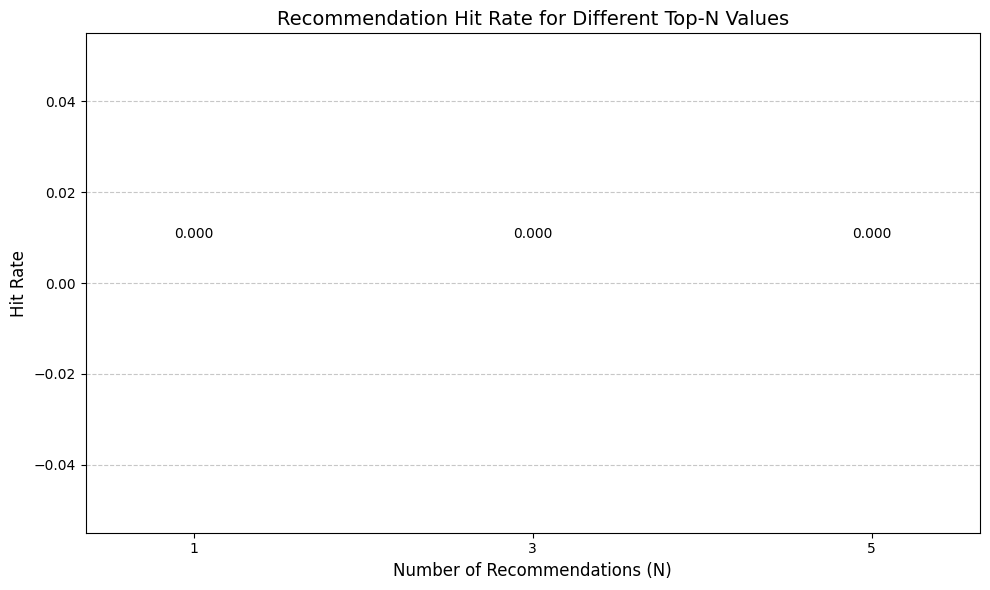

In [18]:
# Evaluate with different numbers of recommendations
evaluation_results = {}
for n in [1, 3, 5]:
    evaluation_results[n] = evaluate_recommendations(test_customers, n)

# Print evaluation results
print("\nEvaluation Results:")
for n, metrics in evaluation_results.items():
    print(f"Top-{n} recommendations:")
    print(f"  Precision@{n}: {metrics['precision']:.4f}")
    print(f"  Recall@{n}: {metrics['recall']:.4f}")
    print(f"  Hit Rate: {metrics['hit_rate']:.4f}")

# Cell 8: Visualize model performance
# Create bar chart of hit rate for different top-N values
plt.figure(figsize=(10, 6))
hit_rates = [metrics['hit_rate'] for metrics in evaluation_results.values()]
top_n_values = list(evaluation_results.keys())

plt.bar(top_n_values, hit_rates, color='teal')
plt.title('Recommendation Hit Rate for Different Top-N Values', fontsize=14)
plt.xlabel('Number of Recommendations (N)', fontsize=12)
plt.ylabel('Hit Rate', fontsize=12)
plt.xticks(top_n_values)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on the bars
for i, v in enumerate(hit_rates):
    plt.text(top_n_values[i], v + 0.01, f"{v:.3f}", ha='center', fontsize=10)

plt.tight_layout()
plt.show()


In [19]:
# Create a model object that includes everything needed for recommendations
recommendation_model = {
    'service_similarity': service_similarity_df,
    'service_features': service_features,
    'tfidf_vectorizer': tfidf,
    'scaler': scaler,
    'service_mapping': service_indices
}

# Save the model using joblib
joblib.dump(recommendation_model, 'recommendation_model.pkl')
print("Model saved as 'recommendation_model.pkl'")

# Cell 10: Function to recommend services for new customers
def recommend_for_new_customer(customer_features, top_n=3):
    """
    Recommend services for a new customer based on their features.

    Parameters:
    customer_features: Dictionary with customer features such as booking frequency, spending
    top_n: Number of recommendations to return

    Returns:
    List of recommended services
    """
    # For a new customer with no service history, we'll use their features
    # to find the most suitable services

    # Convert customer features to vector
    customer_vector = np.zeros(service_features.shape[1])

    # Fill in the known features (e.g., booking frequency, avg spending)
    if 'Booking_Frequency' in customer_features:
        # Normalize the value using the same scaler as services
        bf_idx = service_features.columns.get_loc('Booking_Frequency')
        normalized_bf = (customer_features['Booking_Frequency'] - scaler.mean_[0]) / scaler.scale_[0]
        customer_vector[bf_idx] = normalized_bf

    if 'Avg_Spending' in customer_features:
        # Normalize the value
        as_idx = service_features.columns.get_loc('Avg_Spending')
        normalized_as = (customer_features['Avg_Spending'] - scaler.mean_[1]) / scaler.scale_[1]
        customer_vector[as_idx] = normalized_as

    # Calculate similarity between customer vector and all services
    similarities = cosine_similarity([customer_vector], service_feature_matrix)[0]

    # Get top N services
    service_indices = np.argsort(similarities)[::-1][:top_n]
    recommended_services = [service_features.index[idx] for idx in service_indices]

    return recommended_services

# Example usage for a new customer
new_customer = {
    'Booking_Frequency': 5,
    'Avg_Spending': 500
}

print("\nRecommendations for a new customer:")
print(f"Customer profile: {new_customer}")
new_customer_recommendations = recommend_for_new_customer(new_customer)
print(f"Recommended services: {new_customer_recommendations}")

# Cell 11: Function to get similar customers
def get_similar_customers(customer_id, top_n=5):
    """
    Find similar customers based on their service preferences and features.

    Parameters:
    customer_id: ID of the customer
    top_n: Number of similar customers to return

    Returns:
    List of similar customer IDs
    """
    # Get the customer's profile
    if customer_id not in user_profiles:
        return "Customer ID not found in profiles"

    customer_profile = user_profiles[customer_id]

    # Calculate similarity with all other customers
    similarities = []
    for other_id, other_profile in user_profiles.items():
        if other_id != customer_id:
            # Convert profiles to vectors
            customer_vector = np.array(list(customer_profile.values()))
            other_vector = np.array(list(other_profile.values()))

            # Calculate cosine similarity
            similarity = cosine_similarity([customer_vector], [other_vector])[0][0]
            similarities.append((other_id, similarity))

    # Sort by similarity (descending)
    similarities.sort(key=lambda x: x[1], reverse=True)

    # Return top N similar customers
    return similarities[:top_n]

# Example usage
test_customer = list(user_profiles.keys())[0]
print(f"\nFinding similar customers to customer {test_customer}:")
similar_customers = get_similar_customers(test_customer)
print(similar_customers)

Model saved as 'recommendation_model.pkl'

Recommendations for a new customer:
Customer profile: {'Booking_Frequency': 5, 'Avg_Spending': 500}
Recommended services: ['Hair Cut Colouring and Styling', 'Sports Massage', 'Corporate Massage']

Finding similar customers to customer 1001:
[(1017, np.float64(1.0000000000000004)), (1037, np.float64(1.0000000000000004)), (1043, np.float64(1.0000000000000004)), (1072, np.float64(1.0000000000000004)), (1075, np.float64(1.0000000000000004))]
